## 藏头诗生成（训练模型）

#### 1. 基本设置

In [1]:
# 禁用词，包含如下字符的唐诗将被忽略
DISALLOWED_WORDS = ['（', '）', '(', ')', '__', '《', '》', '【', '】', '[', ']']

# 句子最大长度
MAX_LEN = 100

# 最小词频
MIN_WORD_FREQUENCY = 12

# 训练的batch size
BATCH_SIZE = 40

# 数据集路径
DATASET_PATH = './poetry.txt'

# 每个epoch训练完成后，随机生成SHOW_NUM首古诗作为展示
SHOW_NUM = 2

# 共训练多少个epoch
TRAIN_EPOCHS = 15

# 最佳权重保存路径
BEST_MODEL_PATH = './best_model.h5'

#### 2. 导入要用到的第三方库

In [2]:
import os
from collections import Counter
import math
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#### 3. 构建数据集、分词器以及训练用数据生成器

In [3]:
class Tokenizer:
    """
    分词器
    """
    def __init__(self, token_dict):
        # 词->编号的映射
        self.token_dict = token_dict
        # 编号->词的映射
        self.token_dict_rev = {value: key for key, value in self.token_dict.items()}
        # 词汇表大小
        self.vocab_size = len(self.token_dict)

    def id_to_token(self, token_id):
        """
        给定一个编号，查找词汇表中对应的词
        :param token_id: 带查找词的编号
        :return: 编号对应的词
        """
        return self.token_dict_rev[token_id]

    def token_to_id(self, token):
        """
        给定一个词，查找它在词汇表中的编号
        未找到则返回低频词[UNK]的编号
        :param token: 带查找编号的词
        :return: 词的编号
        """
        return self.token_dict.get(token, self.token_dict['[UNK]'])

    def encode(self, tokens):
        """
        给定一个字符串s，在头尾分别加上标记开始和结束的特殊字符，并将它转成对应的编号序列
        :param tokens: 待编码字符串
        :return: 编号序列
        """
        # 加上开始标记
        token_ids = [self.token_to_id('[CLS]'), ]
        # 加入字符串编号序列
        for token in tokens:
            token_ids.append(self.token_to_id(token))
        # 加上结束标记
        token_ids.append(self.token_to_id('[SEP]'))
        return token_ids

    def decode(self, token_ids):
        """
        给定一个编号序列，将它解码成字符串
        :param token_ids: 待解码的编号序列
        :return: 解码出的字符串
        """
        # 起止标记字符特殊处理
        spec_tokens = {'[CLS]', '[SEP]'}
        # 保存解码出的字符的list
        tokens = []
        for token_id in token_ids:
            token = self.id_to_token(token_id)
            if token in spec_tokens:
                continue
            tokens.append(token)
        # 拼接字符串
        return ''.join(tokens)


class Dataset:
    """
    数据集类
    """
    def __init__(self, load_cache=True):
        if load_cache and \
           os.path.exists(f'./dataset_{MAX_LEN}_{MIN_WORD_FREQUENCY}.json') and \
           os.path.exists(f'./tokenizer_{MAX_LEN}_{MIN_WORD_FREQUENCY}.json'):
            # 从文件中加载数据集
            self.poetry = json.load(open(f'./dataset_{MAX_LEN}_{MIN_WORD_FREQUENCY}.json', 'r', encoding='utf-8'))
            self.tokenizer = Tokenizer(json.load(open(f'./tokenizer_{MAX_LEN}_{MIN_WORD_FREQUENCY}.json', 'r', encoding='utf-8')))
        else:
            # 加载数据集
            with open(DATASET_PATH, 'r', encoding='utf-8') as f:
                lines = f.readlines()
                # 将冒号统一成相同格式
                lines = [line.replace('：', ':') for line in lines]
            # 诗词集列表
            poetry = []
            # 逐行处理读取到的数据
            for line in lines:
                # 有且只能有一个冒号用来分割标题
                if line.count(':') != 1: continue
                # 后半部分不能包含禁止词
                _, last_part = line.split(':')
                ignore_flag = False
                for dis_word in DISALLOWED_WORDS:
                    if dis_word in last_part:
                        ignore_flag = True
                        break
                if ignore_flag: continue
                # 长度不能超过最大长度
                if len(last_part) > MAX_LEN - 2: continue
                poetry.append(last_part.replace('\n', ''))

            # 统计词频
            counter = Counter()
            for line in poetry: counter.update(line)
            # 过滤掉低频词
            tokens = [(token, count) for token, count in counter.items() if count >= MIN_WORD_FREQUENCY]
            # 按词频排序
            tokens = sorted(tokens, key=lambda x: -x[1])
            # 去掉词频，只保留词列表
            tokens = [token for token, count in tokens]
            # 将特殊词和数据集中的词拼接起来
            tokens = ['[PAD]', '[UNK]', '[CLS]', '[SEP]'] + tokens
            # 创建词典 token->id映射关系
            token_id_dict = dict(zip(tokens, range(len(tokens))))
            # 使用新词典重新建立分词器
            self.tokenizer = Tokenizer(token_id_dict)
            # 混洗数据
            np.random.shuffle(poetry)
            self.poetry = poetry
            # 保存诗集和词表缓存
            json.dump(self.poetry, open(f'./dataset_{MAX_LEN}_{MIN_WORD_FREQUENCY}.json', 'w', encoding='utf-8'), ensure_ascii=False)
            json.dump(token_id_dict, open(f'./tokenizer_{MAX_LEN}_{MIN_WORD_FREQUENCY}.json', 'w', encoding='utf-8'), ensure_ascii=False)
    
    def __len__(self):
        return len(self.poetry)

class PoetryDataGenerator:
    """
    古诗训练数据集生成器
    """
    def __init__(self, data, tokenizer, batch_size=BATCH_SIZE, random=False):
        # 数据集
        self.data = data
        self.tokenizer = tokenizer
        # batch size
        self.batch_size = batch_size
        # 每个epoch迭代的步数
        self.steps = int(math.floor(len(self.data) / self.batch_size))
        # 每个epoch开始时是否随机混洗
        self.random = random

    def sequence_padding(self, data, length=None, padding=None):
        """
        将给定数据填充到相同长度
        :param data: 待填充数据
        :param length: 填充后的长度, 不传递此参数则使用data中的最大长度
        :param padding: 用于填充的数据，不传递此参数则使用[PAD]的对应编号
        :return: 填充后的数据
        """
        # 计算填充长度
        if length is None:
            length = max(map(len, data))
        # 计算填充数据
        if padding is None:
            padding = self.tokenizer.token_to_id('[PAD]')
        # 开始填充
        outputs = []
        for line in data:
            padding_length = length - len(line)
            # 不足就进行填充
            if padding_length > 0:
                outputs.append(np.concatenate([line, [padding] * padding_length]))
            # 超过就进行截断
            else:
                outputs.append(line[:length])
        return np.array(outputs)

    def __len__(self):
        return self.steps

    def __iter__(self):
        total = len(self.data)
        # 是否随机混洗
        if self.random:
            np.random.shuffle(self.data)
        # 迭代一个epoch，每次yield一个batch
        for start in range(0, total, self.batch_size):
            end = min(start + self.batch_size, total)
            batch_data = []
            # 逐一对古诗进行编码
            for single_data in self.data[start:end]:
                batch_data.append(self.tokenizer.encode(single_data))
            # 填充为相同长度
            batch_data = self.sequence_padding(batch_data)
            # yield x,y
            yield batch_data[:, :-1], tf.one_hot(batch_data[:, 1:], self.tokenizer.vocab_size)
            del batch_data

    def for_fit(self):
        """
        创建一个生成器，用于训练
        """
        # 死循环，当数据训练一个epoch之后，重新迭代数据
        while True:
            # 委托生成器
            yield from self.__iter__()

dataset = Dataset(load_cache=True)
poetry = dataset.poetry
tokenizer = dataset.tokenizer

##### 3.1 查看词表、诗集大小并查看前十首诗

In [4]:
# 查看数据集信息
print("诗集总数: ", len(poetry))
print("词表大小: ", tokenizer.vocab_size)
print("前十首诗:\n", '\n'.join(poetry[:10]))

诗集总数:  37038
词表大小:  3748
前十首诗:
 垂白方为县，徒知大父雄。山春南去棹，楚夜北飞鸿。叠嶂和云灭，孤城与岭通。谁知持惠化，一境动清风。
烟霞海边寺，高卧出门慵。白日少来客，清风生古松。虚窗从燕入，坏屐任苔封。几度陪师话，相留到暮钟。
红粉青楼曙，垂杨仲月春。怀君重攀折，非妾妒腰身。舞带萦丝断，娇娥向叶嚬。横吹凡几曲，独自最愁人。
鹤书犹未至，那出白云来。旧路经年别，寒潮每日回。家空归海燕，人老发江梅。最忆门前柳，闲居手自栽。
游子惜春暮，策杖出蒿莱。正直康庄晚，群公谒帝回。履度南宫至，车从北阙来。珂影傍明月，笳声动落梅。迎风采旄转，照日绶花开。红尘掩鹤盖，翠柳拂龙媒。绮云临舞阁，丹霞薄吹台。轻肥宁所羡，未若反山隈。
云戟曙沈沈，轩墀清且深。家传成栋美，尧宠结茅心。玉佩多依石，油幢亦在林。炉香诸洞暖，殿影众山阴。草奏风生笔，筵开雪满琴。客从龙阙至，僧自虎溪寻。潇洒延清赏，周流会素襟。终朝惜尘步，一醉见华簪。
年少家藏累代金，红楼尽日醉沈沈。马非躞蹀宁酬价，人不婵娟肯动心。
草露前朝事，荆茅圣主封。空传馀竹帛，永绝旧歌钟。清镜无双影，穷泉有几重。笳箫最悲处，风入九原松。
适楚岂吾愿，思归秋向深。故人江楼月，永夜千里心。叶落觉乡梦，鸟啼惊越吟。寥寥更何有，断续空城砧。
晚日临寒渚，微风发棹讴。凤池波自阔，鱼水运难留。亭古思宏栋，川长忆夜舟。想公高世志，只似冶城游。


In [5]:
# 检验分词器
enc = tokenizer.encode(poetry[0])
print(enc)
print(tokenizer.decode(enc))

[2, 274, 36, 158, 39, 853, 4, 513, 30, 255, 1294, 795, 5, 8, 16, 67, 35, 715, 4, 253, 37, 182, 91, 583, 5, 901, 1436, 287, 13, 891, 4, 180, 71, 111, 561, 305, 5, 104, 30, 621, 1239, 521, 4, 12, 859, 265, 46, 9, 5, 3]
垂白方为县，徒知大父雄。山春南去棹，楚夜北飞鸿。叠嶂和云灭，孤城与岭通。谁知持惠化，一境动清风。


In [6]:
# 检查分词器前十个token对应的文本
for i in range(10):
    print(i, tokenizer.token_dict_rev[i])

0 [PAD]
1 [UNK]
2 [CLS]
3 [SEP]
4 ，
5 。
6 不
7 人
8 山
9 风


#### 4. 定义藏头诗生成函数

In [7]:
def generate_acrostic(tokenizer, model, head):
    """
    随机生成一首藏头诗
    :param tokenizer: 分词器
    :param model: 用于生成古诗的模型
    :param head: 藏头诗的头
    :return: 一个字符串，表示一首古诗
    """
    # 使用空串初始化token_ids，加入[CLS]
    token_ids = tokenizer.encode('')
    token_ids = token_ids[:-1]
    # 标点符号
    punctuations = ['，', '。', '？', '！', '；']
    punctuation_ids = {tokenizer.token_to_id(token) for token in punctuations}
    # 缓存生成的诗的list
    poetry = []
    # 对于藏头诗中的每一个字，都生成一个短句
    for ch in head:
        # 先记录下这个字
        poetry.append(ch)
        # 将藏头诗的字符转成token id
        token_id = tokenizer.token_to_id(ch)
        # 加入到列表中去
        token_ids.append(token_id)
        # 开始生成一个短句
        for _ in range(MAX_LEN // len(head)):
            # 进行预测，只保留第一个样例（我们输入的样例数只有1）的、最后一个token的预测的、不包含[PAD][UNK][CLS]的概率分布
            output = model(np.array([token_ids, ], dtype=np.int32))
            _probas = output.numpy()[0, -1, 3:]
            del output
            # 按照出现概率，对所有token倒序排列
            p_args = _probas.argsort()[::-1][:100]
            # 排列后的概率顺序
            p = _probas[p_args]
            # 先对概率归一
            p = p / sum(p)
            # 再按照预测出的概率，随机选择一个词作为预测结果
            target_index = np.random.choice(len(p), p=p)
            target = p_args[target_index] + 3
            # 保存
            token_ids.append(target)
            # 只有不是特殊字符时，才保存到poetry里面去
            if target > 3:
                poetry.append(tokenizer.id_to_token(target))
            if target in punctuation_ids:
                poetry.append('\n')
                break
    return ''.join(poetry)

#### 5. 定义改进的模块

In [8]:
# 构建词嵌入层（带位置嵌入）
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=input_dim, output_dim=output_dim)
        self.position_embeddings = tf.keras.layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim
  
    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions
 
    def get_config(self):
        config = super().get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

# 自注意力 + MLP投影 模块 (Transformer块)
class SelfAttentionWrapper(tf.keras.layers.Layer):
    def __init__(self, num_heads, key_dim, **kwargs):
        super(SelfAttentionWrapper, self).__init__()
        self.multi_head_attention = tf.keras.layers.MultiHeadAttention(
            num_heads, key_dim, **kwargs)
        self.ln1 = tf.keras.layers.LayerNormalization()
        self.ln2 = tf.keras.layers.LayerNormalization()
        self.dense_proj = tf.keras.Sequential([
            tf.keras.layers.Dense(
                key_dim / 4, activation="relu"
            ),
            tf.keras.layers.Dense(key_dim),
        ])
        self.num_heads = num_heads
        self.key_dim = key_dim
    
    @tf.function
    def call(self, inputs):
        outputs = self.ln1(inputs + self.multi_head_attention(inputs, inputs, inputs))
        proj_outputs = self.dense_proj(outputs)
        return self.ln2(outputs + proj_outputs)

    
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_heads": self.num_heads,
            "key_dim": self.key_dim,
        })
        return config

# 交叉熵 + KL散度 损失函数
@tf.function
def loss_fn_mix(y_true, y_pred):
    ce = tf.keras.losses.CategoricalCrossentropy()
    kld = tf.keras.losses.KLDivergence()
    return 0.8 * ce(y_true, y_pred) + 0.2 * kld(y_true, y_pred)

#### 6. 构建LSTM模型

In [9]:
# 设置混合精度训练策略
tf.keras.mixed_precision.set_global_policy('mixed_float16')

# 构建模型
model = tf.keras.Sequential([
    # 不定长度的输入
    tf.keras.layers.Input((None,)),

    # 词嵌入层
    # tf.keras.layers.Embedding(input_dim=tokenizer.vocab_size, output_dim=128),
    PositionalEmbedding(sequence_length=MAX_LEN, input_dim=tokenizer.vocab_size, output_dim=320),

    # 自注意力层
    SelfAttentionWrapper(4, 320),

    # 第一个LSTM层，返回序列作为下一层的输入
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128, dropout=0.05, return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.L2(0.01),
            recurrent_regularizer=tf.keras.regularizers.L2(0.02),
            bias_regularizer=tf.keras.regularizers.L2(0.01),
        )
    ),

    # 第二个LSTM层，返回序列作为下一层的输入
    tf.keras.layers.Bidirectional(
        tf.keras.layers.LSTM(
            128, dropout=0.05, return_sequences=True,
            kernel_regularizer=tf.keras.regularizers.L2(0.01),
            recurrent_regularizer=tf.keras.regularizers.L2(0.02),
            bias_regularizer=tf.keras.regularizers.L2(0.01),
        )
    ),

    # 对每一个时间点的输出都做softmax，预测下一个词的概率
    # tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(tokenizer.vocab_size, activation='softmax')),

    # 自注意力层
    SelfAttentionWrapper(4, 256),

    # 全连接层，最后做softmax输出下一个词的概率
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(tokenizer.vocab_size),
    tf.keras.layers.Activation('softmax', dtype='float32'),
])

# 查看模型结构
model.summary()

# 配置优化器和损失函数
model.compile(optimizer=tf.keras.optimizers.Adam(), loss=loss_fn_mix)

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: NVIDIA GeForce RTX 2060, compute capability 7.5


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 positional_embedding (Posit  (None, None, 320)        1231360   
 ionalEmbedding)                                                 
                                                                 
 self_attention_wrapper (Sel  (None, None, 320)        1695440   
 fAttentionWrapper)                                              
                                                                 
 bidirectional (Bidirectiona  (None, None, 256)        459776    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, None, 256)        394240    
 nal)                                                            
                                                                 
 self_attention_wrapper_1 (S  (None, None, 256)       

#### 7. 设置回调函数

In [10]:
# 定义 checkpoint 回调函数
checkpoint_prefix = './checkpoints/poetry_ckpt'
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_prefix,
    save_weights_only=True,
    monitor='loss',
    mode='min',
    save_best_only=True)

# 定义 early stop 回调函数
patience = 3
early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=patience)

# 定义评估回调
class Evaluate(tf.keras.callbacks.Callback):
    """
    训练过程评估回调, 在每个epoch训练完成后, 保留最优权重, 并随机生成SHOW_NUM首古诗展示
    """
    def __init__(self):
        super().__init__()
        # 给loss赋一个较大的初始值
        self.lowest = 1e10

    def on_epoch_end(self, epoch, logs=None):
        # 在每个epoch训练完成后调用
        # 如果当前loss更低，就保存当前模型参数
        if logs['loss'] <= self.lowest:
            self.lowest = logs['loss']
            model.save(BEST_MODEL_PATH)
        # 随机生成几首古体诗测试，查看训练效果
        print("\n")
        for i in range(SHOW_NUM):
            print(generate_acrostic(tokenizer, model, head="自然语言处理"))

#### 8. 训练模型

In [11]:
# 创建数据集
data_generator = PoetryDataGenerator(poetry, tokenizer, BATCH_SIZE, random=True)

# 开始训练
history = model.fit(data_generator.for_fit(), 
                    steps_per_epoch=data_generator.steps,
                    epochs=TRAIN_EPOCHS,
                    callbacks=[
                        checkpoint_callback,
                        early_stop,
                        # tf.keras.callbacks.TensorBoard(log_dir="./logs", update_freq=50),
                        # tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5, patience=2, min_lr=1e-5),
                        Evaluate(),
                    ])


Epoch 1/15
925/925 [==============================] - ETA: 0s - loss: 4.9233

自无自生有山新人。
然，
语。
言。
处玉还何人。
理。

自空归玉将出。
然前别过多。
语，
言更江，
处。
理，

925/925 [==============================] - 112s 110ms/step - loss: 4.9233
Epoch 2/15
925/925 [==============================] - ETA: 0s - loss: 4.5141

自。
然色闲来。
语。
言独多白出，
处。
理得风。

自不生花，
然，
语花，
言君。
处重时。
理江在，

925/925 [==============================] - 103s 111ms/step - loss: 4.5141
Epoch 3/15
925/925 [==============================] - ETA: 0s - loss: 4.2880

自门里。
然，
语此，
言声处，
处得空。
理别。

自。
然城春明山得高相人，
语出万闲日春思不多月，
言时朝江，
处处为三来如更。
理未前更。

925/925 [==============================] - 104s 112ms/step - loss: 4.2880
Epoch 4/15
925/925 [==============================] - ETA: 0s - loss: 4.2785

自白事。
然君。
语。
言玉何为去山香长多春向，
处独三。
理。

自。
然不，
语江。
言此。
处上自年下白夜三别山山在。
理春一云自。

925/925 [==============================] - 104s 112ms/step - loss: 4.2785
Epoch 5/15
925/925 [==============================] - ETA: 0s - loss: 3.7195

自。
然在为时，
语有春来，
言雨秋林无，
处家无，
理长君远雨，

自，
然来中重。
语在树心，
言空

#### 9. 绘制训练损失图

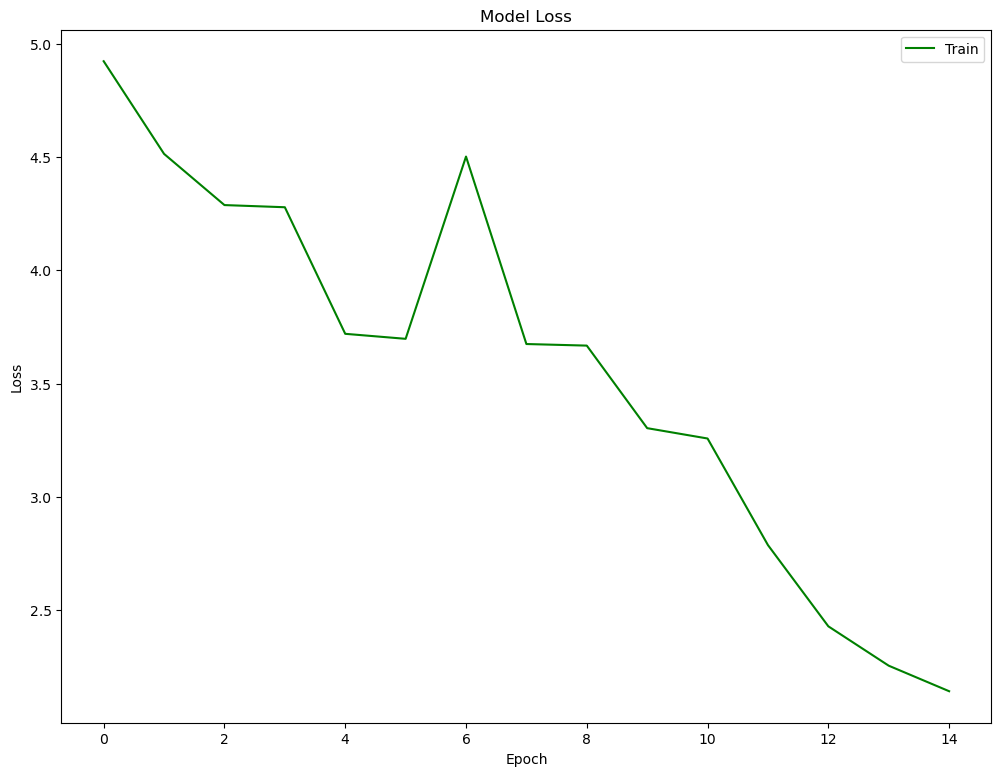

In [12]:
plt.figure(figsize=(12,9))
plt.plot(history.history['loss'], 'g')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train'], loc='upper right')
plt.show()

#### 10. 测试模型，生成藏头诗

In [13]:
# 加载训练好的模型
model = tf.keras.models.load_model(BEST_MODEL_PATH, 
                                   custom_objects={
                                       'PositionalEmbedding': PositionalEmbedding, 
                                       'SelfAttentionWrapper': SelfAttentionWrapper,
                                       'loss_fn_mix': loss_fn_mix,
                                    })

# 设置藏头诗的关键字
keywords = "自然语言处理"

# 生成藏头诗
print(generate_acrostic(tokenizer, model, head=keywords))

自况高归相不衣。
然是时山花流。
语与多来花地去子。
言行此见处山。
处明烟人起落香深。
理中长声色流处人，

